# Rodent Complaint Prediction 

----

**Summary**

- Removed columns which were either mostly NULLs and which were too noisy (intuitively) to add value as an independent variable
- Created "day_of_week" flag as categorical feature from "Created Date"
- Removed 4th Category from "Descriptor" feature after first model iteration to improve accuracy from 56% to 71%
- Combined "Location Type" to Residential and Non-Residential and observed increase in accuracy from 71% to 76%
- Given the time frame, I unable to perform multiple Grid-Searchs because of limited local CPU performance
- NULL values in Coordinates were imputed using cluster centroids (mean) based on respective "Borough" cluster
- Used Bagging RandomForest and XGBoost models for predicting type of rodent complaint
- Model Test-Set Accuracy for 80-20 train-test split after hyperparameter tuning was 76%

----

In [354]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score, precision_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import xgboost
import pickle

# display settings for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [355]:
# importing complaints data
complaints_df = pd.read_csv("complaints.csv")

In [356]:
# Taking 3 labels as required for prediction as first model iteration results were poor
complaints_df = complaints_df.loc[complaints_df['Descriptor'].isin(['Rat Sighting', 'Mouse Sighting', 'Signs of Rodents'])]

## Stats

In [357]:
# shape of data
complaints_df.shape

(2394, 40)

In [358]:
# how many records are NAs for each column
complaints_df.isna().sum()

Unnamed: 0                           0
Unique Key                           0
Created Date                         0
Closed Date                        204
Agency                               0
Agency Name                          0
Complaint Type                       0
Descriptor                           0
Location Type                        0
Incident Zip                         4
Incident Address                   150
Street Name                        150
Cross Street 1                     716
Cross Street 2                     717
Intersection Street 1             2246
Intersection Street 2             2246
Address Type                         3
City                                 4
Landmark                          2393
Facility Type                     2394
Status                               0
Due Date                             0
Resolution Description               0
Resolution Action Updated Date       0
Community Board                      0
Borough                  

In [359]:
complaints_df['Descriptor'].value_counts()

Rat Sighting        1775
Mouse Sighting       405
Signs of Rodents     214
Name: Descriptor, dtype: int64

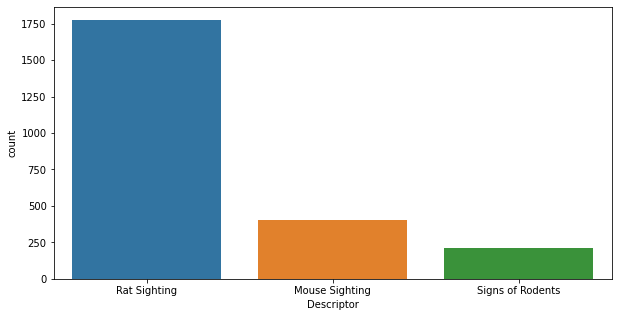

In [360]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Descriptor',data=complaints_df);

---

In [361]:
# correct date format
complaints_df['Created Date'] = pd.to_datetime(complaints_df['Created Date'], errors='coerce')
complaints_df['Closed Date'] = pd.to_datetime(complaints_df['Closed Date'], errors='coerce')

---

##  Data Exploration

### Removing Junk Columns

In [362]:
# checking columns which are mostly NAs by creating a DF with fraction of NAs to total length of data
junk_col_list = pd.DataFrame(complaints_df.isna().sum() / complaints_df.shape[0], columns=['na_fraction']).reset_index()

# taking 90% threshold of NA to remove junk columns which will not any value in model training 
junk_col_list = junk_col_list.loc[junk_col_list['na_fraction'] >= 0.90]
junk_col_list

,index,na_fraction
14,Intersection Street 1,0.938179
15,Intersection Street 2,0.938179
18,Landmark,0.999582
19,Facility Type,1.000000
30,Vehicle Type,1.000000
31,Taxi Company Borough,1.000000
32,Taxi Pick Up Location,1.000000
33,Bridge Highway Name,1.000000
34,Bridge Highway Direction,1.000000
35,Road Ramp,1.000000


In [363]:
# removing identified columns from complaints_df
complaints_df.drop(columns=junk_col_list['index'], inplace=True)

### Exploring Remaining Columns

In [364]:
complaints_df.head()

,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Address Type,City,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,Latitude,Longitude,Location
0,0,34223255,2016-09-01,2016-09-02,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Catch Basin/Sewer,10037.0,EAST 135 STREET,EAST 135 STREET,MADISON AVENUE,HARLEM RIVER DRIVE EXIT 21 NB,BLOCKFACE,NEW YORK,Closed,10/01/2016 04:23:55 PM,The Department of Health and Mental Hygiene wi...,09/02/2016 12:00:00 AM,Unspecified MANHATTAN,MANHATTAN,NaN,NaN,Unspecified,MANHATTAN,NaN,NaN,NaN
1,1,34226273,2016-09-01,2017-01-24,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Vacant Lot,NaN,19,19,10 AVE,11 AVE,NaN,NaN,Closed,10/01/2016 02:25:00 PM,The Department of Health and Mental Hygiene wi...,01/24/2017 12:00:00 AM,Unspecified BROOKLYN,BROOKLYN,NaN,NaN,Unspecified,BROOKLYN,NaN,NaN,NaN
2,2,34213129,2016-09-01,2016-09-04,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Mixed Use Building,11238.0,147 GREENE AVENUE,GREENE AVENUE,WAVERLY AVENUE,WASHINGTON AVENUE,ADDRESS,BROOKLYN,Closed,10/01/2016 01:17:58 AM,The Department of Health and Mental Hygiene wi...,09/04/2016 12:00:00 AM,02 BROOKLYN,BROOKLYN,993633.0,189453.0,Unspecified,BROOKLYN,40.686677,-73.966167,"(40.68667651821694, -73.96616742133907)"
3,3,34214146,2016-09-01,2016-09-07,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11203.0,813 EAST 51 STREET,EAST 51 STREET,AVENUE D,FOSTER AVENUE,ADDRESS,BROOKLYN,Closed,10/01/2016 02:03:32 AM,The Department of Health and Mental Hygiene wi...,09/07/2016 12:00:00 AM,17 BROOKLYN,BROOKLYN,1004167.0,172906.0,Unspecified,BROOKLYN,40.641241,-73.928234,"(40.641241249401865, -73.92823353964022)"
4,4,34216119,2016-09-01,2016-09-07,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11203.0,776 EAST 52 STREET,EAST 52 STREET,AVENUE D,FOSTER AVENUE,ADDRESS,BROOKLYN,Closed,10/01/2016 01:59:10 AM,The Department of Health and Mental Hygiene wi...,09/07/2016 12:00:00 AM,17 BROOKLYN,BROOKLYN,1004421.0,172914.0,Unspecified,BROOKLYN,40.641263,-73.927318,"(40.64126263285648, -73.92731828387933)"


---

In [365]:
# removing first "Unnamed:0" column which is possibly an index which got saved while writing data to CSV
complaints_df = complaints_df.iloc[:,1:]

---

In [366]:
# Unique Key
complaints_df['Unique Key'].nunique() == complaints_df.shape[0]

# removing Unique key from data as its just an ID
complaints_df.drop(columns='Unique Key', inplace=True)

True

---

In [367]:
# Agency
complaints_df['Agency'].value_counts()
complaints_df['Agency Name'].value_counts()

# Removing Agency and Agency Name as it has same category for all rows and it would add no additional value in model
complaints_df.drop(columns=['Agency', 'Agency Name'], inplace=True)

DOHMH    2394
Name: Agency, dtype: int64

Department of Health and Mental Hygiene    2394
Name: Agency Name, dtype: int64

---

In [368]:
# complaint type
complaints_df['Complaint Type'].value_counts()

# removing complaint type as its just one category for all rows and would add no value in final model
complaints_df.drop(columns='Complaint Type', inplace=True)

Rodent    2394
Name: Complaint Type, dtype: int64

---

In [369]:
# dependent variable or labels which we are going to predict
complaints_df['Descriptor'].value_counts()

Rat Sighting        1775
Mouse Sighting       405
Signs of Rodents     214
Name: Descriptor, dtype: int64

---

In [370]:
complaints_df['Location Type'].value_counts()

3+ Family Apt. Building          1079
1-2 Family Dwelling               445
Other (Explain Below)             336
3+ Family Mixed Use Building      132
Commercial Building               127
Vacant Lot                         78
Construction Site                  69
Vacant Building                    44
1-2 Family Mixed Use Building      28
Catch Basin/Sewer                  21
Parking Lot/Garage                 15
Public Garden                       8
Day Care/Nursery                    3
School/Pre-School                   2
Single Room Occupancy (SRO)         2
Public Stairs                       2
Office Building                     2
Government Building                 1
Name: Location Type, dtype: int64

---

In [371]:
# Incident Zip Code
complaints_df['Incident Zip'].nunique()

# removing zip code as we can use coordinate information in model
complaints_df.drop(columns='Incident Zip', inplace=True)

169

---

In [372]:
complaints_df['Incident Address'].nunique()
complaints_df['Street Name'].nunique()
complaints_df['Cross Street 1'].nunique()
complaints_df['Cross Street 2'].nunique()

# removing subjective columns with address details
complaints_df.drop(columns=[ 'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2'], inplace=True)

1836

1142

738

735

In [373]:
complaints_df['Address Type'].value_counts()

ADDRESS         1572
LATLONG          590
INTERSECTION     147
BLOCKFACE         81
PLACENAME          1
Name: Address Type, dtype: int64

---

In [374]:
complaints_df['City'].value_counts()

# removing CIty as most frequent categories are similar to borough
complaints_df.drop(columns='City', inplace=True)

BROOKLYN               743
NEW YORK               674
BRONX                  481
STATEN ISLAND          104
Jamaica                 42
Astoria                 28
Ridgewood               27
Corona                  13
East Elmhurst           12
Woodside                12
Elmhurst                11
SOUTH OZONE PARK        10
Flushing                10
JAMAICA                 10
Saint Albans            10
Middle Village           9
Ozone Park               9
Far Rockaway             8
ROCKAWAY PARK            8
FAR ROCKAWAY             7
Bayside                  7
RIDGEWOOD                7
Queens Village           6
Long Island City         6
Maspeth                  6
CENTRAL PARK             6
South Ozone Park         6
ASTORIA                  6
Rockaway Park            5
South Richmond Hill      5
Woodhaven                5
Springfield Gardens      5
Jackson Heights          5
Richmond Hill            4
Whitestone               4
Hollis                   4
College Point            4
W

---

In [375]:
# Status
complaints_df['Status'].value_counts()

# Dropping Status as it has nothing to do with rodent category
complaints_df.drop(columns='Status', inplace=True)

Closed      2170
Assigned     148
Pending       76
Name: Status, dtype: int64

---

In [376]:
complaints_df['Due Date']

# due date based on type of complaint - adds no value
complaints_df.drop(columns='Due Date', inplace=True)

0       10/01/2016 04:23:55 PM
1       10/01/2016 02:25:00 PM
2       10/01/2016 01:17:58 AM
3       10/01/2016 02:03:32 AM
4       10/01/2016 01:59:10 AM
                 ...          
3096    10/30/2016 02:02:17 PM
3097    10/30/2016 11:29:01 AM
3098    10/30/2016 10:37:09 AM
3099    10/30/2016 11:18:41 PM
3100    10/30/2016 11:29:33 AM
Name: Due Date, Length: 2394, dtype: object

---

In [377]:
complaints_df['Resolution Description'].value_counts()

# removing junk column
complaints_df.drop(columns='Resolution Description', inplace=True)

The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status                                                                    2393
The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status.  Please note your Service Request number for future reference.       1
Name: Resolution Description, dtype: int64

---

In [378]:
complaints_df['Resolution Action Updated Date']

# Removing for first iteration
complaints_df.drop(columns='Resolution Action Updated Date', inplace=True)

0       09/02/2016 12:00:00 AM
1       01/24/2017 12:00:00 AM
2       09/04/2016 12:00:00 AM
3       09/07/2016 12:00:00 AM
4       09/07/2016 12:00:00 AM
                 ...          
3096    10/13/2016 12:00:00 AM
3097    10/02/2016 12:00:00 AM
3098    09/30/2016 10:42:59 AM
3099    10/06/2016 12:00:00 AM
3100    10/03/2016 12:00:00 AM
Name: Resolution Action Updated Date, Length: 2394, dtype: object

---

In [379]:
complaints_df['Community Board'].value_counts()

# removing Community Board as categories are similar to borough
complaints_df.drop(columns='Community Board', inplace=True)

Unspecified MANHATTAN        268
Unspecified BROOKLYN         226
Unspecified QUEENS           119
Unspecified BRONX            102
03 BROOKLYN                   92
08 MANHATTAN                  76
04 BRONX                      53
03 MANHATTAN                  52
07 MANHATTAN                  50
10 MANHATTAN                  48
01 STATEN ISLAND              46
05 BRONX                      45
01 BROOKLYN                   43
16 BROOKLYN                   43
12 MANHATTAN                  43
17 BROOKLYN                   41
05 QUEENS                     41
09 BRONX                      41
03 BRONX                      40
07 BRONX                      39
04 BROOKLYN                   39
12 QUEENS                     37
08 BROOKLYN                   37
04 MANHATTAN                  34
01 QUEENS                     34
02 BROOKLYN                   33
12 BRONX                      33
09 MANHATTAN                  33
08 BRONX                      33
09 BROOKLYN                   32
05 BROOKLY

---

In [380]:
complaints_df['Borough'].value_counts()
# good categorical feature

BROOKLYN         745
MANHATTAN        680
BRONX            483
QUEENS           382
STATEN ISLAND    104
Name: Borough, dtype: int64

---

In [381]:
complaints_df['Park Borough'].value_counts()

BROOKLYN         745
MANHATTAN        680
BRONX            483
QUEENS           382
STATEN ISLAND    104
Name: Park Borough, dtype: int64

In [382]:
# check equality between Borough and Park Borough
complaints_df['Borough'].equals(complaints_df['Park Borough'])

True

In [383]:
# removing "Park Borough" as it is exactly equal to "Borough"
complaints_df.drop(columns='Park Borough', inplace=True)

---

In [384]:
# park facility name
complaints_df['Park Facility Name'].value_counts()

# removing park facility name as it has same category for all rows and it would add no additional value in model
complaints_df.drop(columns='Park Facility Name', inplace=True)

Unspecified    2394
Name: Park Facility Name, dtype: int64

---

In [385]:
# dropping lat, long and location as we can use X,Y coordinates
complaints_df.drop(columns=['Latitude','Longitude','Location'], inplace=True)

---

In [386]:
# Dropping Closed Date
complaints_df.drop(columns='Closed Date', inplace=True)

---

## Deep Dive on Variables

In [387]:
# renaming variables
complaints_df.rename(columns={"X Coordinate (State Plane)" : 'X_Coordinate',
                             "Y Coordinate (State Plane)" : "Y_Coordinate"}, inplace=True)

### Missing Values

In [388]:
complaints_df.isna().sum()

Created Date      0
Descriptor        0
Location Type     0
Address Type      3
Borough           0
X_Coordinate     19
Y_Coordinate     19
dtype: int64

**Coordinates**

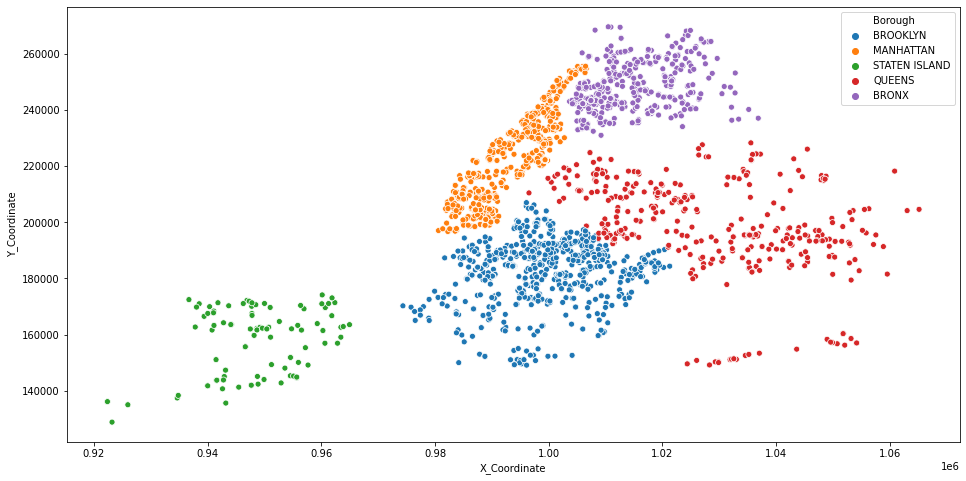

In [389]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x='X_Coordinate',y='Y_Coordinate',data=test_label_df,hue='Borough');

Boroughs are good clusters and their centroids can be used to impute the missing values

In [390]:
# groupby Borough and imputing NAs in coordinates with mean of each category
complaints_df['X_Coordinate'] = complaints_df.groupby("Borough")['X_Coordinate'].transform(lambda x: x.fillna(x.mean()))
complaints_df['Y_Coordinate'] = complaints_df.groupby("Borough")['Y_Coordinate'].transform(lambda x: x.fillna(x.mean()))

---

**Address Type**

In [391]:
# removing 3 rows with NA in Address Type
complaints_df.dropna(inplace=True)

---

### Feature Creation

**Day of Week**

In [395]:
complaints_df['day_of_week'] = complaints_df['Created Date'].dt.day_name()

Most requests were created on Thursday and least on Sunday

In [396]:
complaints_df['day_of_week'].value_counts()

Thursday     459
Wednesday    401
Friday       385
Tuesday      384
Monday       320
Saturday     237
Sunday       205
Name: day_of_week, dtype: int64

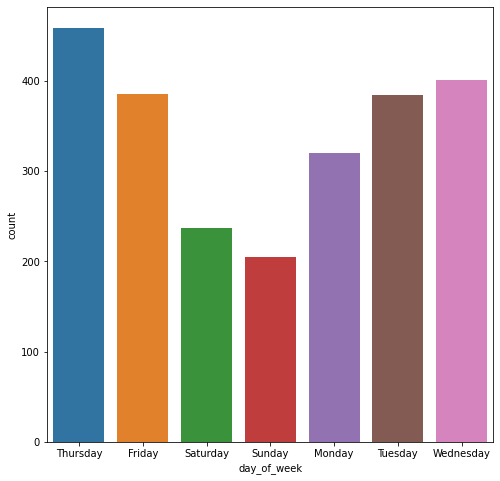

In [397]:
plt.figure(figsize=(8, 8))
sns.countplot(x='day_of_week',data=complaints_df);

----

**Location Type**

In [398]:
complaints_df['Location Type'].value_counts()

3+ Family Apt. Building          1079
1-2 Family Dwelling               445
Other (Explain Below)             335
3+ Family Mixed Use Building      132
Commercial Building               126
Vacant Lot                         77
Construction Site                  69
Vacant Building                    44
1-2 Family Mixed Use Building      28
Catch Basin/Sewer                  21
Parking Lot/Garage                 15
Public Garden                       8
Day Care/Nursery                    3
School/Pre-School                   2
Single Room Occupancy (SRO)         2
Public Stairs                       2
Office Building                     2
Government Building                 1
Name: Location Type, dtype: int64

Different categories can be merged together - example Residential / Non - Residential

In [399]:
residential_categories = ['3+ Family Mixed Use Building', '1-2 Family Dwelling',
                          '3+ Family Apt. Building','1-2 Family Mixed Use Building',
                          'Single Room Occupancy (SRO)']

In [400]:
# Updating Location Type from multiple categories to Binary based on residential location
complaints_df['Location Type'] = np.where(complaints_df['Location Type'].isin(residential_categories),"Residential","Non-Residential")

In [401]:
complaints_df['Location Type'].value_counts()

Residential        1686
Non-Residential     705
Name: Location Type, dtype: int64

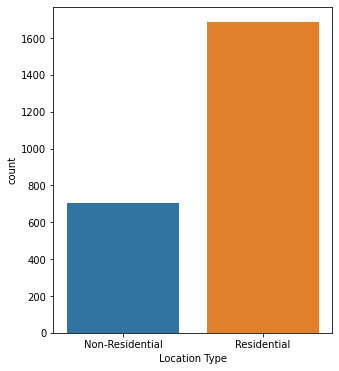

In [402]:
plt.figure(figsize=(5, 6))
sns.countplot(x='Location Type',data=complaints_df);

----

In [403]:
# Dropping Created Date before modeling
complaints_df.drop(columns='Created Date', inplace=True)

----

## Modeling

Given Categorical variables and non-parametric nature its good to choose tree based methods

In [419]:
# creating copy from cleaned and formatted DF
final_df = complaints_df.copy()

In [420]:
# resetting index
final_df.reset_index(drop=True, inplace=True)

In [421]:
final_df.head()

,Descriptor,Location Type,Address Type,Borough,X_Coordinate,Y_Coordinate,day_of_week
0,Rat Sighting,Non-Residential,BLOCKFACE,MANHATTAN,9.936099e+05,222724.076119,Thursday
1,Rat Sighting,Residential,ADDRESS,BROOKLYN,9.936330e+05,189453.000000,Thursday
2,Rat Sighting,Residential,ADDRESS,BROOKLYN,1.004167e+06,172906.000000,Thursday
3,Rat Sighting,Residential,ADDRESS,BROOKLYN,1.004421e+06,172914.000000,Thursday
4,Mouse Sighting,Residential,LATLONG,MANHATTAN,9.894000e+05,207641.000000,Thursday


---

In [422]:
# arranging columns
final_df = final_df.loc[:,['Location Type', 'Address Type', 'Borough', 'day_of_week',
                'X_Coordinate', 'Y_Coordinate', 'Descriptor']]

In [423]:
# One Hot Encoding categorical Variables
var_categorical = ['Location Type', 'Address Type', 'Borough', 'day_of_week']
categorical_df = pd.get_dummies(final_df.loc[:,var_categorical], drop_first=True)
final_df = pd.concat([categorical_df,final_df.drop(columns=var_categorical)], axis=1)

In [424]:
# Creating the dependent variable factors and storinng definitions
factor = pd.factorize(final_df['Descriptor'])
final_df['Descriptor'] = factor[0]
definitions = factor[1]

---

### Train - Test Split

In [500]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state = 42, stratify = y)

### RandomForest

In [501]:
# Fitting baseline Random Forest Classification to the Training set
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

RandomForestClassifier(random_state=42)

In [502]:
# TEST
print('accuracy: %.4f'% accuracy_score(y_pred=y_pred, y_true=y_test))

accuracy: 0.7244


In [484]:
#Reverse factorize
reversefactor = dict(zip(range(4),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

In [485]:
# Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted         Mouse Sighting  Rat Sighting  Signs of Rodents
Actual                                                          
Mouse Sighting                16            63                 2
Rat Sighting                  25           325                 5
Signs of Rodents               3            34                 6


### XGBoost

In [496]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state = 42, stratify = y)

In [497]:
# Fitting baseline XGboost Classification to the Training set
model = xgboost.XGBRFClassifier(random_state = 42)
# model = xgboost.XGBClassifier(random_state = 42)
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

#Reverse factorize
reversefactor = dict(zip(range(4),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='multi:softprob', random_state=42, reg_alpha=0,
                scale_pos_weight=None, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [498]:
print('accuracy: %.4f'% accuracy_score(y_pred=y_pred, y_true=y_test))

accuracy: 0.7370


In [499]:
# Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted         Mouse Sighting  Rat Sighting  Signs of Rodents
Actual                                                          
Mouse Sighting                 7            73                 1
Rat Sighting                   5           342                 8
Signs of Rodents               1            38                 4


----

### RandomSearchCV

Trying to improve baseline XGBoost model based on hyperparameters tuning

In [438]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state = 42, stratify = y)

In [352]:
distributions = {'max_depth' : [3,5,6,10],
                'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5],
                'n_estimators': [80,100,150,200],
                'gamma': [0, 0.1, 0.5, 1, 2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]}

In [440]:
xgb = xgboost.XGBRFClassifier()
model = RandomizedSearchCV(xgb, distributions, random_state=42, n_jobs=-1)
search = model.fit(X_train, y_train)
search.best_params_

### GridSearchCV

Grid Search based on few iterations from RandomSearch

In [441]:
grid = {'max_depth' : [6,8,10,12],
                'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5],
                'n_estimators': [100,120,150,160,180],
                'gamma': [0.5, 0.75, 1, 1.25, 1.5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]}

In [442]:
xgb = xgboost.XGBRFClassifier()
model = GridSearchCV(xgb, grid, n_jobs=-1)
search = model.fit(X_train, y_train)
search.best_params_

In [469]:
# model based on optimum hyperparameters
model = xgboost.XGBRFClassifier(
     colsample_bytree= 0.6,
     gamma= 0.5,
     learning_rate= 0.01,
     max_depth= 10,
     n_estimators= 200,
     subsample= 1.0)

In [470]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [471]:
print('accuracy: %.4f'% accuracy_score(y_pred=y_pred, y_true=y_test))
print('recall: %.4f'% recall_score(y_pred=y_pred, y_true=y_test,average='micro'))

accuracy: 0.7573
recall: 0.7573


In [473]:
importance_df = pd.DataFrame({"Feature": list(X_test.columns), "gini_importance_%": list(100*model.feature_importances_)})
importance_df = importance_df.sort_values('gini_importance_%', ascending=False)
importance_df

,Feature,gini_importance_%
3,Address Type_LATLONG,23.327919
0,Location Type_Residential,18.569963
16,Y_Coordinate,5.687449
15,X_Coordinate,5.672132
6,Borough_MANHATTAN,5.392201
8,Borough_STATEN ISLAND,4.786777
7,Borough_QUEENS,4.772870
1,Address Type_BLOCKFACE,4.566598
2,Address Type_INTERSECTION,4.517962
5,Borough_BROOKLYN,4.224378


In [474]:
#Reverse factorize
reversefactor = dict(zip(range(4),definitions))

y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

In [475]:
print(classification_report(y_pred, y_test))

                  precision    recall  f1-score   support

  Mouse Sighting       0.11      0.69      0.19        13
    Rat Sighting       0.99      0.76      0.86       464
Signs of Rodents       0.02      1.00      0.05         1

        accuracy                           0.76       478
       macro avg       0.38      0.82      0.37       478
    weighted avg       0.97      0.76      0.84       478



---

## Cross Validation

In [452]:
# Define X and y matrix
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]

In [453]:
# Create 5-Folds 
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X, y)

5

In [454]:
# for train_index, test_index in kf.split(X, Y):
for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    
    print("X test size: {} ; X train size: {}".format(len(X_test), len(X_train)))
    # print the various evaluation metrics
    print('Test Accuracy: %.4f'% accuracy_score(y_pred=y_pred, y_true=y_test))

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

X test size: 479 ; X train size: 1912
Test Accuracy: 0.7537


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

X test size: 478 ; X train size: 1913
Test Accuracy: 0.7699


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

X test size: 478 ; X train size: 1913
Test Accuracy: 0.7448


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

X test size: 478 ; X train size: 1913
Test Accuracy: 0.7573


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

X test size: 478 ; X train size: 1913
Test Accuracy: 0.7573


**Model test-test accuracies are stable across all 5 folds**

----

**Creating model on full dataset which can be tested on validation set**

In [476]:
# model based on optimum hyperparameters
xgb_model = xgboost.XGBRFClassifier(
     colsample_bytree= 0.6,
     gamma= 0.5,
     learning_rate= 0.01,
     max_depth= 10,
     n_estimators= 200,
     subsample= 1.0)

# Fit entire data
xgb_model.fit(X, y)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=10,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=0, num_parallel_tree=200,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=1.0, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [477]:
# save model to pickle file
pickle.dump(xgb_model, open("xgb_model_v1.pkl", 'wb'))

----